#### Requires
    - Torch
    - numpy
    - matplotlib
    - Gpytorch ; pip install gpytorch
    - Botorch ; pip install botorch


In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from botorch.acquisition.analytic import ExpectedImprovement
from torch.distributions import Normal

In [2]:
## Underlying true ('ground') objective
ground_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
ground_y = torch.sin(ground_x * (2 * math.pi))# + torch.randn(actual_x.size()) * math.sqrt(0.04)


In [3]:
# Generating initial training data

torch.manual_seed(1) # seed for reproducibility
# Training data 5 points selected 
train_x = torch.tensor([0.01, 0.10, 0.85, 0.90, 0.95])
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) #+ torch.randn(train_x.size()) * math.sqrt(0.02)


In [4]:
# simple GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


In [5]:
# Fitting of the model with training set
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

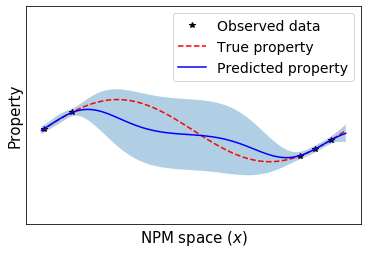

In [6]:
# Plotting Figure 3 in the paper
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed data')
    plt.plot(ground_x.numpy(), ground_y.numpy(),'r--', label='True property')
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='Predicted property')
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.35)
    plt.ylim([-3, 4])
    plt.xlabel('NPM space ($x$)', fontsize=15)
    plt.ylabel('Property', fontsize=15)
    plt.yticks([])
    plt.xticks([])
    plt.legend(fontsize=14)
    #plt.savefig("gp_1.pdf")

In [7]:
# computing expected improvement objective for test points 
posterior = model(test_x)
mean = posterior.mean
sigma = posterior.variance.clamp_min(1e-9).sqrt()#.view(view_shape)
u = (mean - torch.max(train_y).expand_as(mean)) / sigma
normal = Normal(torch.zeros_like(u), torch.ones_like(u))
ucdf = normal.cdf(u)
updf = torch.exp(normal.log_prob(u))
ei = sigma * (updf + u * ucdf)

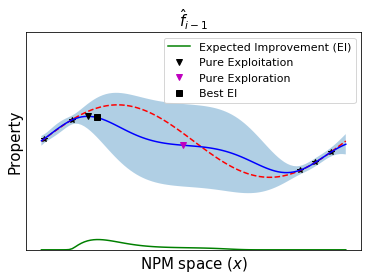

In [8]:
# Plotting figure 4 (a) 
with torch.no_grad():
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
    plt.plot(ground_x.numpy(), ground_y.numpy(),'r--')
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.35)
    plt.plot(test_x.numpy(), 2*(ei.numpy())-3, 'g', label='Expected Improvement (EI)')

    plt.plot(test_x[torch.argmax(observed_pred.mean)].numpy(), observed_pred.mean[torch.argmax(observed_pred.mean)].numpy(), 'kv', label='Pure Exploitation')
    plt.plot(test_x[torch.argmax(observed_pred.stddev)].numpy(), observed_pred.mean[torch.argmax(observed_pred.stddev)].numpy(), 'mv', label='Pure Exploration')
    plt.plot(test_x[torch.argmax(ei)].numpy(), observed_pred.mean[torch.argmax(ei)].numpy(), 'ks', label='Best EI')
    plt.ylim([-3, 3])
    plt.xlabel('NPM space ($x$)', fontsize=15)
    plt.ylabel('Property', fontsize=15)
    plt.yticks([])
    plt.xticks([])
    plt.title('$\hat{f}_{i-1}$', fontsize=15)
    plt.legend(fontsize=11)#['Expected Improvement'])
    #plt.savefig("gp_ei_1.pdf")

In [9]:
## update training set with new point (one with highest EI value)
new_train_x = torch.cat([train_x, test_x[torch.argmax(ei)].unsqueeze(0)])
new_train_y = torch.sin(new_train_x * (2 * math.pi)) #+ torch.randn(new_train_x.size()) * math.sqrt(0.04)

In [10]:
## Fit the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(new_train_x, new_train_y, likelihood)
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(new_train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, new_train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

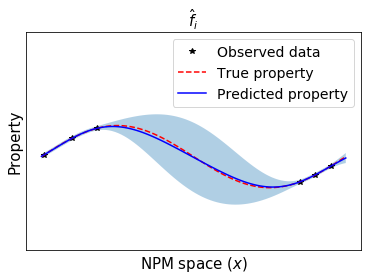

In [11]:
## Plotting figure 4(b)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    plt.plot(new_train_x.numpy(), new_train_y.numpy(), 'k*', label='Observed data')
    plt.plot(ground_x.numpy(), ground_y.numpy(),'r--', label='True property')
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='Predicted property')
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.35)
    plt.ylim([-3, 4])
    plt.xlabel('NPM space ($x$)', fontsize=15)
    plt.ylabel('Property', fontsize=15)
    plt.yticks([])
    plt.xticks([])
    plt.legend(fontsize=14)
    plt.title('$\hat{f}_{i}$', fontsize=15)
    #plt.savefig("gp_ei_2.pdf")